# Disease Outbreak Response Decision-making Under Uncertainty: A retrospective analysis of measles in Sao Paulo

In [53]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
import pdb

from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

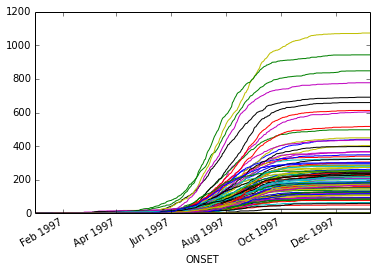

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

In [9]:
total_district_cases = measles_onset_dist.sum()

Top 5 districts by number of cases

In [10]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

Age distribution of cases, by confirmation status

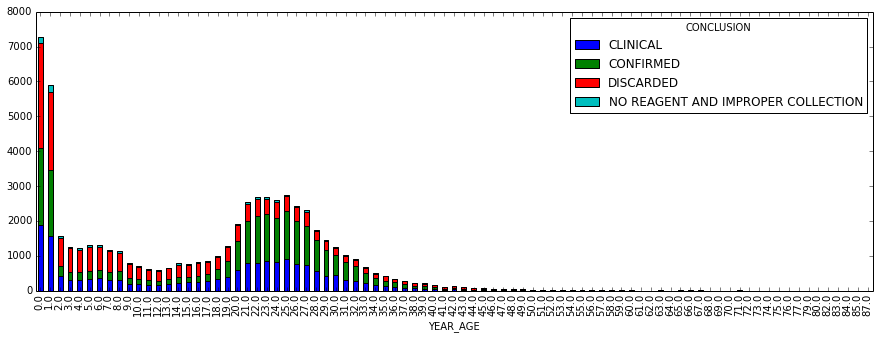

In [11]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

## Vaccination data

In [12]:
vaccination_data = pd.read_csv('data/BrazilVaxRecords.csv', index_col=0)
vaccination_data.head()

,BIRTHS,VAX,POP,SIA
YEAR,,,,
1980,3896442,0.57,121740438,0
1981,3933136,0.73,124610790,0
1982,3952137,0.66,127525420,0
1983,3952735,0.68,130455659,0
1984,3935224,0.73,133364277,0


In [13]:
vaccination_data.VAX[:18]

YEAR
1980    0.57
1981    0.73
1982    0.66
1983    0.68
1984    0.73
1985    0.67
1986    0.67
1987    0.64
1988    0.62
1989    0.60
1990    0.78
1991    0.85
1992    0.91
1993    0.85
1994    0.77
1995    0.87
1996    0.80
1997    0.99
Name: VAX, dtype: float64

In [14]:
vax_97 = np.r_[[0]*(1979-1921+1), vaccination_data.VAX[:17]]
n = len(vax_97)
FOI_mat = np.resize((1 - vax_97*0.9), (n,n)).T

In [15]:
# Mean age of infection for those born prior to vaccination coverage, assuming R0=16
A = 4.37

In [16]:
(1 - vax_97*0.9)[:-1]

array([ 1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  0.487,  0.343,  0.406,  0.388,  0.343,
        0.397,  0.397,  0.424,  0.442,  0.46 ,  0.298,  0.235,  0.181,
        0.235,  0.307,  0.217])

In [17]:
np.tril(FOI_mat).sum(0)

array([ 64.84 ,  63.84 ,  62.84 ,  61.84 ,  60.84 ,  59.84 ,  58.84 ,
        57.84 ,  56.84 ,  55.84 ,  54.84 ,  53.84 ,  52.84 ,  51.84 ,
        50.84 ,  49.84 ,  48.84 ,  47.84 ,  46.84 ,  45.84 ,  44.84 ,
        43.84 ,  42.84 ,  41.84 ,  40.84 ,  39.84 ,  38.84 ,  37.84 ,
        36.84 ,  35.84 ,  34.84 ,  33.84 ,  32.84 ,  31.84 ,  30.84 ,
        29.84 ,  28.84 ,  27.84 ,  26.84 ,  25.84 ,  24.84 ,  23.84 ,
        22.84 ,  21.84 ,  20.84 ,  19.84 ,  18.84 ,  17.84 ,  16.84 ,
        15.84 ,  14.84 ,  13.84 ,  12.84 ,  11.84 ,  10.84 ,   9.84 ,
         8.84 ,   7.84 ,   6.84 ,   5.84 ,   5.353,   5.01 ,   4.604,
         4.216,   3.873,   3.476,   3.079,   2.655,   2.213,   1.753,
         1.455,   1.22 ,   1.039,   0.804,   0.497,   0.28 ])

In [18]:
natural_susc = np.exp((-1/A) * np.tril(FOI_mat).sum(0))[::-1]
vacc_susc = (1 - vax_97*0.9)[::-1]
vacc_susc[0] = 0.5
vacc_susc

array([ 0.5  ,  0.217,  0.307,  0.235,  0.181,  0.235,  0.298,  0.46 ,
        0.442,  0.424,  0.397,  0.397,  0.343,  0.388,  0.406,  0.343,
        0.487,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ,  1.   ,  1.   ])

In [19]:

sia_susc = np.ones(len(vax_97))
birth_year = np.arange(1922, 1998)[::-1]
by_mask = (birth_year > 1983) & (birth_year < 1992)
sia_susc[by_mask] *= 0.2

## Stochastic Disease Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple SIR disease model, which will be fit using MCMC.

This model fits the series of 2-week infection totals in each district $i$ as a set of Poisson models:

\\[Pr(I(t)_{i} | \lambda(t)_i) = \text{Poisson}(\lambda(t)_i) \\]

Where the outbreak intensity is modeled as:

\\[\lambda(t)_i = \beta [I^{(w)}(t-1)_i]^{\alpha} S(t-1)_i\\]

\\[\alpha \sim \text{Exp}(1)\\]

We will assume here that the transmission rate is constant over time (and across districts):

\\[\beta \sim \text{Gamma}(1, 0.1)\\]

To account for the influence of infected individuals from neighboring districts on new infections, the outbreak intensity was modeled using a spatial-weighted average of infecteds across districts, where populations were weighted as an exponential function of the distance between district centroids:

\\[w_{d} = \text{exp}(-\theta d)\\]

\\[\theta \sim \text{Exp}(1)\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. These estimates are then plugged into the model in place of the clinically-confirmed cases.

We specified a structured confirmation model to retrospectively determine the age group-specific probabilities of lab confirmation for measles, conditional on clinical diagnosis. Individual lab confirmation events $c_i$ were modeled as Bernoulli random variables, with the probability of confirmation being allowed to vary by age group:

$$c_i \sim \text{Bernoulli}(p_{a(i)})$$

where $a(i)$ denotes the appropriate age group for the individual indexed by i. There were 16 age groups, the first 15 of which were 5-year age intervals $[0,5), [5, 10), \ldots , [70, 75)$, with the 16th interval including all individuals 75 years and older.

Since the age interval choices were arbitrary, and the confirmation probabilities of adjacent groups likely correlated, we modeled the correlation structure directly, using a multivariate logit-normal model. Specifically, we allowed first-order autocorrelation among the age groups, whereby the variance-covariance matrix retained a tridiagonal structure. 

$$\begin{aligned}
\Sigma = \left[{
\begin{array}{c}
  {\sigma^2} & {\sigma^2 \rho} & 0& \ldots & {0} & {0}  \\
  {\sigma^2 \rho} & {\sigma^2} &  \sigma^2 \rho & \ldots & {0}  & {0} \\
  {0} & \sigma^2 \rho & {\sigma^2} & \ldots & {0} & {0} \\
  \vdots & \vdots & \vdots &  & \vdots & \vdots\\
  {0} & {0} & 0 & \ldots &  {\sigma^2} & \sigma^2 \rho  \\
{0} & {0} & 0 & \ldots & \sigma^2 \rho &  {\sigma^2} 
\end{array}
}\right]
\end{aligned}$$

From this, the confirmation probabilities were specified as multivariate normal on the inverse-logit scale.

$$ \text{logit}(p_a) = \{a\} \sim N(\mu, \Sigma)$$

Priors for the confirmation sub-model were specified by:

$$\begin{aligned}
\mu_i &\sim N(0, 100) \\
\sigma &\sim \text{HalfCauchy}(25) \\
\rho &\sim U(-1, 1)
\end{aligned}$$

Age classes are defined in 5-year intervals.

In [20]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
measles_data.dropna(subset=['YEAR_AGE'], inplace=True)
measles_data['YEAR_AGE'] = measles_data.YEAR_AGE.astype(int)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [21]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

Extract confirmed and clinical subset, with no missing county information.

In [22]:
lab_subset = measles_data[(CONFIRMED | CLINICAL) & measles_data.COUNTY.notnull()].copy()

In [23]:
age = lab_subset.YEAR_AGE.values
ages = lab_subset.YEAR_AGE.unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values

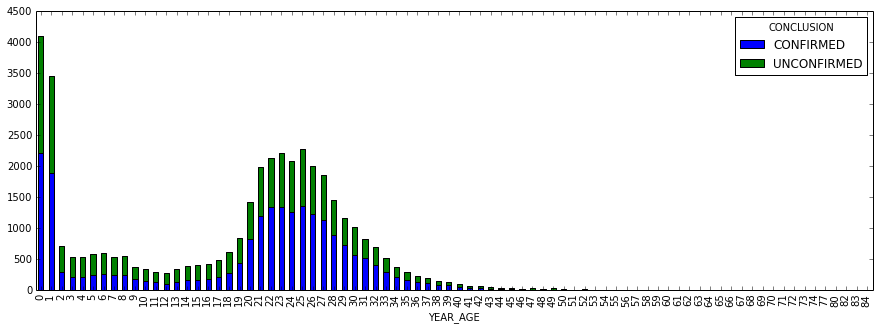

In [24]:
_lab_subset = lab_subset.replace({"CONCLUSION": {"CLINICAL": "UNCONFIRMED"}})
by_conclusion = _lab_subset.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5), grid=False)

In [25]:
lab_subset.shape

(39982, 16)

In [26]:
y.sum()

22097

Proportion of lab-confirmed cases older than 20 years

In [27]:
(measles_data[CONFIRMED].YEAR_AGE>20).mean()

0.60257048468117846

In [28]:
age_classes

[0, 5, 10, 15, 20, 25, 30, 35, 40, 100]

In [29]:
#Extract cases by age and time.
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.categories.tolist().index(i) for i in age_group])
age_groups = age_group.categories
age_groups

Index(['[0, 5)', '[5, 10)', '[10, 15)', '[15, 20)', '[20, 25)', '[25, 30)',
       '[30, 35)', '[35, 40)', '[40, 100)'],
      dtype='object')

In [30]:
age_slice_endpoints = [g[1:-1].split(',') for g in age_groups]
age_slices = [slice(int(i[0]), int(i[1])) for i in age_slice_endpoints]

In [31]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [32]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [33]:
excludes = ['BOM RETIRO']

In [34]:
N = sp_pop.drop(excludes).ix[unique_districts].sum().drop('Total')
N

0 a 4 anos      844130
5 a 9 anos      830880
10 a 14 anos    858750
15 a 19 anos    904972
20 a 24 anos    945244
25 a 29 anos    902086
30 a 34 anos    835888
35 a 39 anos    764605
40 a 44 anos    662946
45 a 49 anos    538872
50 a 54 anos    437744
55 a 59 anos    332195
60 a 64 anos    282850
65 a 69 anos    218202
70 a 74 anos    164842
75 anos e +     203482
dtype: float64

In [35]:
N_age = N.iloc[:8]
N_age.index = age_groups[:-1]
N_age[age_groups[-1]] = N.iloc[8:].sum()
N_age

[0, 5)        844130
[5, 10)       830880
[10, 15)      858750
[15, 20)      904972
[20, 25)      945244
[25, 30)      902086
[30, 35)      835888
[35, 40)      764605
[40, 100)    2841133
dtype: float64

Compile bi-weekly confirmed and unconfirmed data by Sao Paulo district

In [36]:
sp_counts_2w = lab_subset.groupby(
    ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).resample('2W', how='sum')

# All confirmed cases, by district
confirmed_data = lab_subset[lab_subset.CONCLUSION=='CONFIRMED']
confirmed_counts = confirmed_data.groupby(
    ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).sum()

all_confirmed_cases = confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique()).fillna(0)

In [37]:
# Ensure the age groups are ordered
I_obs = sp_counts_2w.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            axis=1).fillna(0).values.astype(int)

Check shape of data frame

- 28 bi-monthly intervals, 9 age groups

In [38]:
assert I_obs.shape == (28, len(age_groups))

Prior distribution on susceptible proportion:

$$p_s \sim \text{Beta}(2, 100)$$

(array([ 2890.,  3430.,  2028.,   925.,   428.,   185.,    73.,    23.,
           11.,     7.]),
 array([ 0.00016355,  0.01061088,  0.02105822,  0.03150555,  0.04195289,
         0.05240023,  0.06284756,  0.0732949 ,  0.08374223,  0.09418957,
         0.10463691]),
 <a list of 10 Patch objects>)

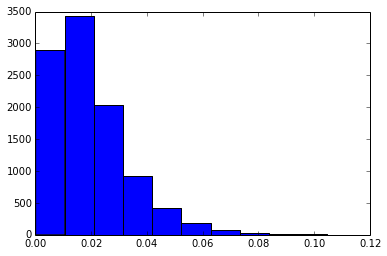

In [39]:
from pymc import rbeta
plt.hist(rbeta(2, 100, 10000))

In [40]:
I_obs

array([[   1,    3,    0,    1,    0,    0,    0,    0,    1],
       [   4,   13,    7,   18,    1,    2,    0,    1,    4],
       [   3,   12,    2,   14,    0,    1,    1,    2,    5],
       [   4,   10,    2,   17,    0,    2,    2,    2,    2],
       [   6,   15,    7,   19,    1,    3,    1,    7,    6],
       [  19,   27,   20,   34,    0,    7,    2,   13,    8],
       [   9,   27,    6,   26,    1,    1,    1,    6,    8],
       [  13,   27,   13,   20,    1,    4,    2,    5,    2],
       [  28,   32,   16,   21,    2,    6,    1,    9,    9],
       [  42,   39,   46,   31,    6,   17,    2,   13,   18],
       [  93,   69,   72,   40,    4,   18,    6,   19,   26],
       [ 157,   95,  153,   64,   12,   47,    5,   31,   42],
       [ 359,  183,  315,  169,   26,   95,   18,   76,   68],
       [ 807,  363,  622,  282,   65,  234,   34,  162,  136],
       [1168,  660, 1035,  388,   87,  398,   63,  257,  166],
       [1442,  913, 1193,  536,  137,  430,   48,  318,

In [41]:
obs_date = '1997-12-01' #'1997-06-15'
obs_index = sp_counts_2w.index <= obs_date
I_obs_t = I_obs[obs_index]

In [42]:
np.sum(I_obs_t, (0)) / float(I_obs_t.sum())

array([ 0.24959899,  0.16916038,  0.22193589,  0.1069447 ,  0.02469168,
        0.08609219,  0.01406821,  0.06923664,  0.05827132])

In [43]:
from pymc import rgamma

(array([   58.,   643.,  2207.,  2931.,  2395.,  1158.,   427.,   135.,
           37.,     9.]),
 array([  4.67771263,   7.63455967,  10.59140672,  13.54825376,
         16.5051008 ,  19.46194785,  22.41879489,  25.37564194,
         28.33248898,  31.28933603,  34.24618307]),
 <a list of 10 Patch objects>)

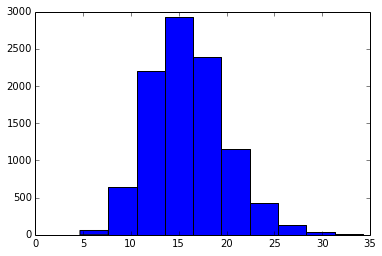

In [44]:
plt.hist(rgamma(16,1,size=10000))

In [45]:
75./age.mean() 

4.1772247118855148

In [46]:
from pymc import MCMC, Matplot, AdaptiveMetropolis, MAP
from pymc import (Uniform, DiscreteUniform, Beta, Binomial, Normal, CompletedDirichlet,
                  Poisson, NegativeBinomial, negative_binomial_like, poisson_like,
                  Lognormal, Exponential, binomial_like,
                  TruncatedNormal, Binomial, Gamma, HalfCauchy, normal_like,
                  MvNormalCov, Bernoulli, Uninformative, 
                  Multinomial, rmultinomial, rbinomial,
                  Dirichlet, multinomial_like)
from pymc import (Lambda, observed, invlogit, deterministic, potential, stochastic,)

def measles_model(obs_date, confirmation=True, spatial_weighting=False, all_traces=True):
    
    n_periods, n_age_groups = I_obs.shape
    
    ### Confirmation sub-model
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(age_classes))
        sig = HalfCauchy('sig', 0, 25, value=1)
        var = sig**2
        cor = Uniform('cor', -1, 1, value=0)

        # Build variance-covariance matrix with first-order correlation 
        # among age classes
        @deterministic
        def Sigma(var=var, cor=cor):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*var*cor
            return I + E + E.T

        # Age-specific probabilities of confirmation as multivariate normal 
        # random variables
        beta_age = MvNormalCov("beta_age", mu=mu, C=Sigma, 
                        value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda t=beta_age: invlogit(t))

        @deterministic(trace=False)
        def p_confirm(beta=beta_age):
            return invlogit(beta[age_index])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=y, 
                                observed=True)


    '''
    Truncate data at observation period
    '''
    obs_index = sp_counts_2w.index <= obs_date
    I_obs_t = I_obs[obs_index]  
                        

    # Index for observation date, used to index out values of interest 
    # from the model.
    t_obs = obs_index.sum() - 1
    
    if confirmation:
        
        @stochastic(trace=all_traces, dtype=int)
        def I(value=(I_obs_t*0.5).astype(int), n=I_obs_t, p=p_age):
            # Binomial confirmation process
            return np.sum([binomial_like(xi, ni, p) for xi,ni in zip(value,n)])

    else:
        
        I = I_obs_t
        
    assert I.shape == (t_obs +1, n_age_groups)
    
    # Transmission parameter
    beta = HalfCauchy('beta', 0, 25, value=[8]*n_age_groups) 

    # Downsample annual series to observed age groups
    downsample = lambda x: np.array([x[s].mean() for s in age_slices])
    
    A = Lambda('A', lambda beta=beta: 75./(beta - 1))
    lt_sum = downsample(np.tril(FOI_mat).sum(0)[::-1])
    natural_susc = Lambda('natural_susc', lambda A=A: np.exp((-1/A) * lt_sum))
    

#     natural_susc = Beta('natural_susc', 1, 1, value=[0.02]*n_age_groups)
    @deterministic
    def p_susceptible(natural_susc=natural_susc): 
        return downsample(sia_susc) * downsample(vacc_susc) * natural_susc
    
    # Estimated total initial susceptibles
    S_0 = Binomial('S_0', n=N_age.astype(int), p=p_susceptible)

    S = Lambda('S', lambda I=I, S_0=S_0: S_0 - I.cumsum(0))
    
    # Check shape
    assert S.value.shape == (t_obs+1., n_age_groups)

    S_t = Lambda('S_t', lambda S=S: S[-1])      
    
    
    @deterministic
    def R(beta=beta, S=S): 
        return (beta * S / N_age.values).T
    
    # Force of infection
    @deterministic
    def lam(beta=beta, I=I, S=S): 
        return (I.sum(1) * (beta * S / N_age.values).T).T
    
    # Check shape
    assert lam.value.shape == (t_obs+1, n_age_groups)
    
    # Poisson likelihood for observed cases
    @potential
    def new_cases(I=I, lam=lam):
        return poisson_like(I[1:], lam[:-1])
    

    return locals()

In [47]:
iterations = 200000
burn = 190000
chains = 2

In [ ]:
M = MCMC(measles_model('1997-06-15', confirmation=True))
for i in range(chains):
    print('\nchain', i+1)
    M.sample(iterations, burn)


 [-----------------100%-----------------] 200000 of 200000 complete in 1157.2 sec

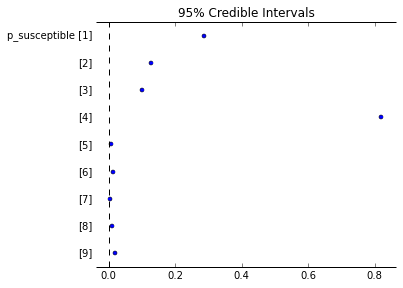

In [54]:
Matplot.summary_plot(M.p_susceptible, chain=-1)

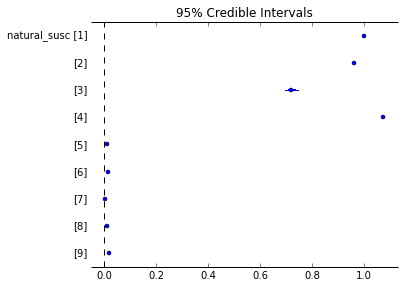

In [55]:
Matplot.summary_plot(M.natural_susc, chain=-1)

In [72]:
M.R.summary()


R:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.255]
	1.285            0.911            0.091            [ 0.338  2.254]
	0.503            0.191            0.019  

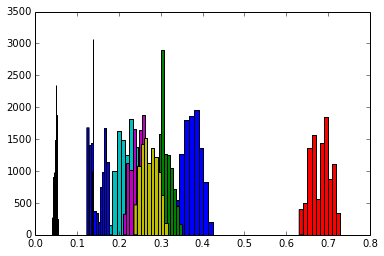

In [74]:
for age in M.R.trace()[:,:,8].T:
    plt.hist(age)